# **M5 Forecasting Walmart - Accuracy**
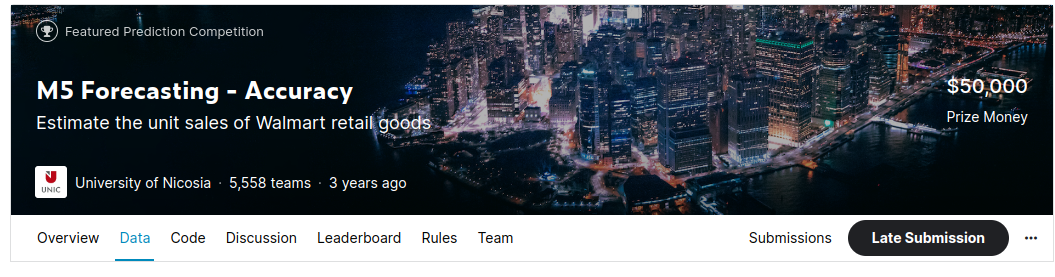
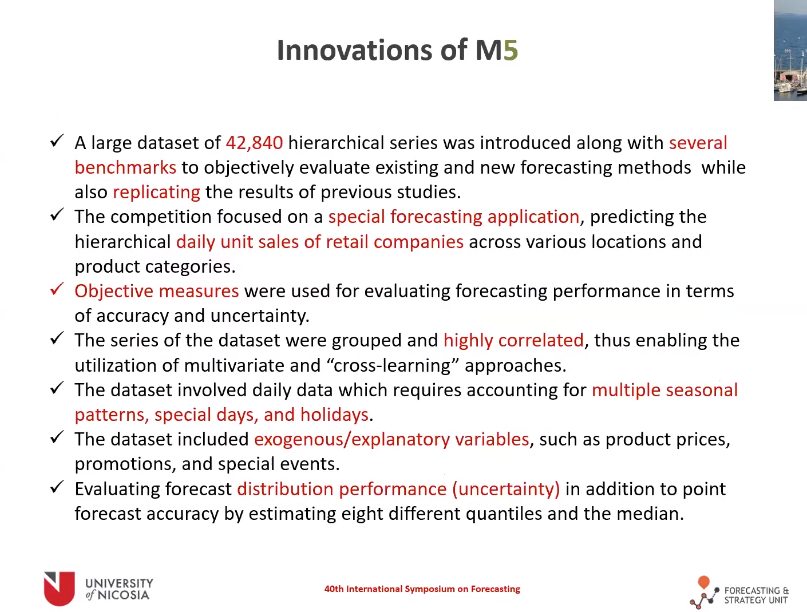

In [1]:
!pip3 install watermark plotly --quiet

In [ ]:
%load_ext watermark
%watermark -a 'NavinKumarMNK' -v -p torch,lightning,cudf,sklearn,polars,plotly

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: NavinKumarMNK

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.12.0

torch    : 2.1.0a0+fe05266
lightning: 2.0.2
cudf     : 23.2.0
sklearn  : 1.2.0
polars   : 0.17.11
plotly   : 5.14.1



In [ ]:
!du -h /workspace/data/M5-Walmart/* | awk '{print $2 "\t" $1}'

/workspace/data/M5-Walmart/calendar.csv	104K
/workspace/data/M5-Walmart/sales_train_evaluation.csv	117M
/workspace/data/M5-Walmart/sales_train_validation.csv	115M
/workspace/data/M5-Walmart/sample_submission.csv	5.0M
/workspace/data/M5-Walmart/sell_prices.csv	194M


## **1. Modules & Setup**

In [ ]:
import dask_cudf as dc
import os 
import cupy as cp
import cuml as ml
import lightgbm as lgbm
import optuna as opt
import plotly as plt
import pickle
import cudf
import pprint
pprint = pprint.pprint

In [ ]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
cluster = LocalCUDACluster()
client = Client(cluster)

/usr/local/lib/python3.8/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36155 instead
  warnings.warn(
2023-05-05 04:59:00,641 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-05 04:59:00,641 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [ ]:
cp.random.seed(42)


## **2. Dataset**

In [ ]:
data_path = '/workspace/data/M5-Walmart/'
artifacts = '/workspace/M5-Walmart/artifacts/'
m5_dataset = [
    'calendar.csv',
    'sales_train_validation.csv',
    'sell_prices.csv',
    'sales_train_evaluation.csv',
]

In [ ]:
cal_df = dc.read_csv(data_path + m5_dataset[0], blocksize="64 KiB")
stv_df = dc.read_csv(data_path + m5_dataset[1], blocksize="32 MiB")
sp_df = dc.read_csv(data_path + m5_dataset[2], blocksize="32 MiB")
ste_df = dc.read_csv(data_path + m5_dataset[3], blocksize="32 MiB")

In [ ]:
print("------ Calender.csv -------")
print(cal_df.npartitions)
cal_df.compute()

------ Calender.csv -------
2


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,<NA>,<NA>,<NA>,<NA>,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,<NA>,<NA>,<NA>,<NA>,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,<NA>,<NA>,<NA>,<NA>,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,<NA>,<NA>,<NA>,<NA>,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,<NA>,<NA>,<NA>,<NA>,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,2016-06-15,11620,Wednesday,5,6,2016,d_1965,<NA>,<NA>,<NA>,<NA>,0,1,1
711,2016-06-16,11620,Thursday,6,6,2016,d_1966,<NA>,<NA>,<NA>,<NA>,0,0,0
712,2016-06-17,11620,Friday,7,6,2016,d_1967,<NA>,<NA>,<NA>,<NA>,0,0,0
713,2016-06-18,11621,Saturday,1,6,2016,d_1968,<NA>,<NA>,<NA>,<NA>,0,0,0


In [ ]:
print("------ Sales_Train_Validation.csv -------")
print(stv_df.npartitions)
stv_df.compute()

------ Sales_Train_Validation.csv -------
4


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4902,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
4903,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4904,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
4905,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [ ]:
print("------ Sales_Train_Evaluation.csv -------")
print(ste_df.npartitions)
ste_df.compute()

------ Sales_Train_Evaluation.csv -------
4


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5264,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
5265,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
5266,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
5267,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [ ]:
print("------ Sell_Prices.csv -------")
print(sp_df.npartitions)
sp_df.compute()

------ Sell_Prices.csv -------
7


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
74382,WI_3,FOODS_3_827,11617,1.00
74383,WI_3,FOODS_3_827,11618,1.00
74384,WI_3,FOODS_3_827,11619,1.00
74385,WI_3,FOODS_3_827,11620,1.00


## **3. Data PreProcessing**


### **3.1 Calender Dataset**

**3.1.1 Label Encode Event Name & Types** 

In [ ]:
event_name_1 = [ j for i, j in enumerate(cal_df['event_name_1'].unique().compute().values_host)] 
pprint(event_name_1)
event_type_1 = [ j for i, j in enumerate(cal_df['event_type_1'].unique().compute().values_host)] 
pprint(event_type_1)

event_name_2 = [ j for i, j in enumerate(cal_df['event_name_2'].unique().compute().values_host)] 
pprint(event_name_2)
event_type_2 = [ j for i, j in enumerate(cal_df['event_type_2'].unique().compute().values_host)] 
pprint(event_type_2)

[None,
 'Chanukah End',
 'Christmas',
 'Cinco De Mayo',
 'ColumbusDay',
 'Easter',
 'Eid al-Fitr',
 'EidAlAdha',
 "Father's day",
 'Halloween',
 'IndependenceDay',
 'LaborDay',
 'LentStart',
 'LentWeek2',
 'MartinLutherKingDay',
 'MemorialDay',
 "Mother's day",
 'NBAFinalsEnd',
 'NBAFinalsStart',
 'NewYear',
 'OrthodoxChristmas',
 'OrthodoxEaster',
 'Pesach End',
 'PresidentsDay',
 'Purim End',
 'Ramadan starts',
 'StPatricksDay',
 'SuperBowl',
 'Thanksgiving',
 'ValentinesDay',
 'VeteransDay']
[None, 'Cultural', 'National', 'Religious', 'Sporting']
[None, 'Cinco De Mayo', 'Easter', "Father's day", 'OrthodoxEaster']
[None, 'Cultural', 'Religious']


In [ ]:
# Event Name & Type (1) is a superset of (2)
event_name, encoded_en = cudf.factorize(cal_df['event_name_1'].compute())
event_type, encoded_tp = cudf.factorize(cal_df['event_type_1'].compute())


In [ ]:
pprint(event_name)
pprint(encoded_en)

name_unique = [] 
for i in event_name:
    if i in name_unique:
        pass
    else :
        name_unique.append(i)

print("Count : ", len(event_name_1), len(name_unique))
print([int(i) for i in name_unique])

array([-1, -1, -1, ..., -1, -1, 16], dtype=int8)
StringIndex(['Chanukah End' 'Christmas' 'Cinco De Mayo' 'ColumbusDay' 'Easter'
 'Eid al-Fitr' 'EidAlAdha' "Father's day" 'Halloween' 'IndependenceDay'
 'LaborDay' 'LentStart' 'LentWeek2' 'MartinLutherKingDay' 'MemorialDay'
 "Mother's day" 'NBAFinalsEnd' 'NBAFinalsStart' 'NewYear'
 'OrthodoxChristmas' 'OrthodoxEaster' 'Pesach End' 'PresidentsDay'
 'Purim End' 'Ramadan starts' 'StPatricksDay' 'SuperBowl' 'Thanksgiving'
 'ValentinesDay' 'VeteransDay'], dtype='object')
Count :  31 31
[-1, 26, 28, 22, 11, 12, 25, 23, 20, 21, 2, 15, 14, 17, 16, 7, 9, 24, 5, 10, 3, 8, 6, 29, 27, 1, 0, 18, 19, 13, 4]


In [ ]:
print(event_type)
print(encoded_tp)

type_unique = [] 
for i in event_type:
    if i in type_unique:
        pass
    else :
        type_unique.append(i)

print("Count : ", len(event_type_1), len(type_unique))
print([int(i) for i in type_unique])

[-1 -1 -1 ... -1 -1  3]
StringIndex(['Cultural' 'National' 'Religious' 'Sporting'], dtype='object')
Count :  5 5
[-1, 3, 0, 1, 2]


- -1 => None
- Other Labels starts from 0 -> 29, where the respetive values are given in StringIndex
- Similarly for Event Types

In [ ]:
name_label_encoding = dict(zip(encoded_en.values_host, [int(i) for i in name_unique[1:]]))
name_label_encoding

with open(artifacts + "event_name_label_encodings.pkl", 'wb') as f:
    pickle.dump(name_label_encoding, f)

In [ ]:
type_label_encoding = dict(zip(encoded_tp.values_host, [int(i) for i in type_unique[1:]]))
type_label_encoding

with open(artifacts + "event_type_label_encodings.pkl", 'wb') as f:
    pickle.dump(type_label_encoding, f)

In [ ]:
cal_df['event_name_1'] = cal_df['event_name_1'].map(name_label_encoding, meta=('event_name_1', 'int8'))
cal_df['event_name_2'] = cal_df['event_name_2'].map(name_label_encoding, meta=('event_name_2', 'int8'))
cal_df['event_type_1'] = cal_df['event_type_1'].map(type_label_encoding, meta=('event_type_1', 'int8'))
cal_df['event_type_2'] = cal_df['event_type_2'].map(type_label_encoding, meta=('event_type_2', 'int8'))

cal_df['event_name_1'] = cal_df['event_name_1'].fillna(-1)
cal_df['event_name_2'] = cal_df['event_name_2'].fillna(-1)
cal_df['event_type_1'] = cal_df['event_type_1'].fillna(-1)
cal_df['event_type_2'] = cal_df['event_type_2'].fillna(-1)

cal_df.compute()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,-1,-1,-1,-1,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,-1,-1,-1,-1,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,-1,-1,-1,-1,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,-1,-1,-1,-1,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,-1,-1,-1,-1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,2016-06-15,11620,Wednesday,5,6,2016,d_1965,-1,-1,-1,-1,0,1,1
711,2016-06-16,11620,Thursday,6,6,2016,d_1966,-1,-1,-1,-1,0,0,0
712,2016-06-17,11620,Friday,7,6,2016,d_1967,-1,-1,-1,-1,0,0,0
713,2016-06-18,11621,Saturday,1,6,2016,d_1968,-1,-1,-1,-1,0,0,0


### **3.2 Sales Train Validataion**

**3.2.1 Label Encoder All the Category Data**

In [ ]:
class LE():
    def __init__(self, df: dc.DataFrame, columns) -> None:
        self.df = df
        self.columns = columns
        self.encoders = {}
        self.encoded = None
    
    def transform(self):
        for column in self.columns:
            print("----- Encoding : ", column, " -----")
            labels, encoded = cudf.factorize(self.df[column].compute())
            print(labels, encoded)
            
            unique = []
            for i in labels:
                if i in unique:
                    pass
                else :
                    unique.append(i)

            print("Count : ", len(labels), len(unique))
            print([int(i) for i in unique])

            label_encoding = dict(zip(encoded.values_host, [int(i) for i in unique]))
            print(len(label_encoding))
            self.save(label_encoding, artifacts + column + "_label_encodings.pkl")
            self.df[column] = self.df[column].map(label_encoding, meta=(column, 'int8'))
            self.df[column] = self.df[column].fillna(-1)
        
        self.df.compute()
        return self.df

    def save(self, label_encoding, path):
        with open(path, 'wb') as f:
            pickle.dump(label_encoding, f)


In [ ]:

label = LE(stv_df, ['dept_id', 'cat_id', 'store_id', 'state_id'])
label.transform()


----- Encoding :  dept_id  -----
[3 3 3 ... 2 2 2] StringIndex(['FOODS_1' 'FOODS_2' 'FOODS_3' 'HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1'
 'HOUSEHOLD_2'], dtype='object')
Count :  30490 7
[3, 4, 5, 6, 0, 1, 2]
7
----- Encoding :  cat_id  -----
[1 1 1 ... 0 0 0] StringIndex(['FOODS' 'HOBBIES' 'HOUSEHOLD'], dtype='object')
Count :  30490 3
[1, 2, 0]
3
----- Encoding :  store_id  -----
[0 0 0 ... 9 9 9] StringIndex(['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3'], dtype='object')
Count :  30490 10
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
10
----- Encoding :  state_id  -----
[0 0 0 ... 2 2 2] StringIndex(['CA' 'TX' 'WI'], dtype='object')
Count :  30490 3
[0, 1, 2]
3
                                 id        item_id  dept_id  cat_id  store_id  \
0     HOBBIES_1_001_CA_1_validation  HOBBIES_1_001        6       2         0   
1     HOBBIES_1_002_CA_1_validation  HOBBIES_1_002        6       2         0   
2     HOBBIES_1_003_CA_1_validation  HOBBIES_1_003        6       2         0  

<dask_cudf.DataFrame | 100 tasks | 4 npartitions>

In [ ]:
stv_df.compute()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,6,2,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,6,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,6,2,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,6,2,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,6,2,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4902,FOODS_3_823_WI_3_validation,FOODS_3_823,5,1,9,2,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
4903,FOODS_3_824_WI_3_validation,FOODS_3_824,5,1,9,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4904,FOODS_3_825_WI_3_validation,FOODS_3_825,5,1,9,2,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
4905,FOODS_3_826_WI_3_validation,FOODS_3_826,5,1,9,2,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [ ]:
label = LE(ste_df, ['dept_id', 'cat_id', 'store_id', 'state_id'])
ste_df = label.transform()


----- Encoding :  dept_id  -----
[3 3 3 ... 2 2 2] StringIndex(['FOODS_1' 'FOODS_2' 'FOODS_3' 'HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1'
 'HOUSEHOLD_2'], dtype='object')
Count :  30490 7
[3, 4, 5, 6, 0, 1, 2]
7
----- Encoding :  cat_id  -----
[1 1 1 ... 0 0 0] StringIndex(['FOODS' 'HOBBIES' 'HOUSEHOLD'], dtype='object')
Count :  30490 3
[1, 2, 0]
3
----- Encoding :  store_id  -----
[0 0 0 ... 9 9 9] StringIndex(['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3'], dtype='object')
Count :  30490 10
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
10
----- Encoding :  state_id  -----
[0 0 0 ... 2 2 2] StringIndex(['CA' 'TX' 'WI'], dtype='object')
Count :  30490 3
[0, 1, 2]
3


In [ ]:
ste_df.compute()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,6,2,0,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,6,2,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,6,2,0,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,6,2,0,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,6,2,0,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5264,FOODS_3_823_WI_3_evaluation,FOODS_3_823,5,1,9,2,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
5265,FOODS_3_824_WI_3_evaluation,FOODS_3_824,5,1,9,2,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
5266,FOODS_3_825_WI_3_evaluation,FOODS_3_825,5,1,9,2,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
5267,FOODS_3_826_WI_3_evaluation,FOODS_3_826,5,1,9,2,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


## **4.Exploratory Data Analysis**

### **4.1 Sales**

## **5. Modelling Time Series**

### **28-days Lag Features**